## Load data

In [1]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
random_state = 12041500

In [6]:
df_train = pd.read_csv("./data2/synthetic_data_DataSynthesizer_correlated_attribute_mode.csv")
df_test = pd.read_json("./data2/testset.json")

ratio_features = ["age", "capital-gain", "capital-loss", "hours-per-week"]
ordinal_features = ["education-num"]
nominal_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex'] + ratio_features
target = 'income'

In [7]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

def clean_data(X: pd.DataFrame) -> pd.DataFrame:
    xX = X.reset_index(drop=True)
    # X = X.drop(columns=["fnlwgt", "education"], errors="ignore")
    cols = list(X.columns)
    X[cols] = X[cols].replace([" ?"], np.nan)
    X = X.dropna()
    
    def strip_str(x):
        if isinstance(x, str):
            return x.strip()
        else:
            return x
    X = X.applymap(strip_str)
    
    X["relationship"] = X["relationship"].replace(["Husband", "Wife"], "Married")
    
    # Define a function to categorize data using KDE
    def categorize_with_kde(series, categories):
        kde = gaussian_kde(series)
        x_values = np.linspace(series.min(), series.max(), 1000)
        pdf_values = kde(x_values)
        
        # Calculate cumulative density function
        cdf_values = np.cumsum(pdf_values)
        cdf_values = cdf_values / cdf_values[-1]
        
        # Find bin edges
        bin_edges = np.interp(np.linspace(0, 1, len(categories) + 1), cdf_values, x_values)
        
        # Digitize the series based on bin edges
        digitized = np.digitize(series, bins=bin_edges[1:-1], right=True)
        
        return pd.Categorical.from_codes(digitized, categories=categories)
    
    # Apply KDE-based categorization to continuous variables
    X["hours-per-week"] = categorize_with_kde(
        X["hours-per-week"], ["PartTime", "MidTime", "FullTime", "OverTime", "BrainDrain"]
    )
    
    X["age"] = categorize_with_kde(
        X["age"], ["Young", "YoungAdult", "Adult", "Senior", "Elder"]
    )
    
    X["capital-gain"] = categorize_with_kde(
        X["capital-gain"], ["None", "Little", "Medium", "High", "Very High"]
    )
    
    X["capital-loss"] = categorize_with_kde(
        X["capital-loss"], ["None", "Little", "Medium", "High", "Very High"]
    )
    
    return X

df_train = clean_data(df_train.dropna())
df_test = clean_data(df_test.dropna())

In [33]:
for col in df_train.columns:
    if df_train[col].dtype == "category":
        df_train[col] = df_train[col].astype("object")
        df_test[col] = df_test[col].astype("object")

In [34]:
display(df_train)

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,income
0,Elder,Private,3.0,Married-civ-spouse,Exec-managerial,Married,White,1,Little,Very High,BrainDrain,0
1,Young,Private,11.0,Divorced,Exec-managerial,Unmarried,White,0,Very High,Little,OverTime,0
2,YoungAdult,Local-gov,9.0,Never-married,Protective-serv,Not-in-family,White,1,Medium,None,FullTime,0
3,Young,Private,7.0,Never-married,Adm-clerical,Own-child,White,1,None,Very High,PartTime,0
4,Senior,Private,14.0,Married-civ-spouse,Other-service,Married,White,1,Little,Little,BrainDrain,0
...,...,...,...,...,...,...,...,...,...,...,...,...
39068,Senior,Private,4.0,Married-civ-spouse,Tech-support,Married,Asian-Pac-Islander,1,Little,Medium,FullTime,1
39069,YoungAdult,Private,13.0,Married-civ-spouse,Prof-specialty,Married,White,1,Little,Very High,OverTime,1
39070,Adult,Local-gov,11.0,Married-civ-spouse,Exec-managerial,Married,White,0,High,Medium,MidTime,1
39071,YoungAdult,Private,1.0,Married-spouse-absent,Adm-clerical,Unmarried,White,0,High,Very High,BrainDrain,0


## Train baseline

In [35]:
from sklearn.linear_model import LogisticRegression
from utils import create_model, train_and_evaluate, describe_model

In [36]:
clf = LogisticRegression(max_iter=1000, random_state=random_state)

In [37]:
## Train baseline
model = create_model(clf, nominal_features)
y_test, y_pred = train_and_evaluate(model, df_train, df_test, target, drop_na=True)
metrics = describe_model(y_test, y_pred, verbose=True)

Metric         Value               
Accuracy       0.817915752064388
Precision      0.7644810066229113
Recall         0.6911075355525242
F1             0.7138743025115764


## Fairness Evaluation

In [38]:
from utils import split_data
from utils_fairness import search_bias, calc_fairness_score, explain_detected_bias

In [39]:
X_train, y_train = split_data(df_train, target, drop_na=True)

In [40]:
model = create_model(clf, nominal_features)
model.fit(X_train, y_train)
probs = pd.Series(model.predict_proba(X_train)[:, 1]) # we select for target label

In [44]:
privileged_subset, _ = search_bias(X_train, y_train, probs, 1, penalty=5)

In [45]:
print(privileged_subset)

({'relationship': ['Own-child'], 'age': ['Young']}, 95.1203)


In [46]:
calc_fairness_score(df_train, privileged_subset[0].keys(), target, verbose=True)

Sensitive Attributes: ['age', 'relationship']

               Group Distance  Proportion  Counts   P-Value
     Senior, Married    0.300    0.118709    4517  0.00e+00
    Young, Own-child   -0.266    0.102494    3900  0.00e+00
               Young   -0.230    0.209719    7980 4.94e-324
             Married    0.192    0.451894   17195 4.94e-324
       Not-in-family   -0.160    0.251741    9579 4.94e-324
           Own-child   -0.188    0.154240    5869 6.00e-293
      Adult, Married    0.235    0.105569    4017 1.05e-218
Young, Not-in-family   -0.237    0.057475    2187 1.59e-197
              Senior    0.143    0.189535    7212 9.86e-152
      Elder, Married    0.185    0.110983    4223 1.14e-145

Weighted Mean Statistical Distance: 0.16281838796637169


In [47]:
explain_detected_bias(df_train, probs, target, privileged_subset[0])

Our detected privileged group has a size of 3900, we observe 0.0 as the average probability of earning >50k, but our model predicts 0.2705


## Fairness Metrics

In [48]:
from utils_fairness import transform_to_bias_dataset, describe_fairness, scan_and_calculate_fairness, plot_fairness_metrics

In [49]:
df_train_bias = transform_to_bias_dataset(df_train, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), verbose=True)
df_test_bias = transform_to_bias_dataset(df_test, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), verbose=True)

In [50]:
model = create_model(clf, nominal_features)
y_test, y_pred = train_and_evaluate(model, df_train, df_train, target, drop_na=True)
metrics = describe_fairness(df_train_bias[target], y_pred, list(privileged_subset[0].keys()), verbose=True)

Metric                          Value               
statistical_parity_difference   0.24139849491962168
average_odds_difference         0.3354515937738597
equal_opportunity_difference    0.5668475579674396
disparate_impact                            0.0
theil_index                     0.14677995819926232


In [51]:
df_fairness_metrics, priviliged_subsets = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "average_abs_odds_difference",
        "equal_opportunity_difference",
        "disparate_impact",
        "theil_index",
    ]
), {}

for i in [0.001, 0.01, 0.1, 1, 5, 25, 50, 100]:
    metrics, priv = scan_and_calculate_fairness(model, df_train, target, i)    
    df_fairness_metrics.loc[f"penalty_{i}"] = metrics.values()
    priviliged_subsets[f"penalty_{i}"] = priv

In [52]:
df_fairness_metrics

,statistical_parity_difference,average_abs_odds_difference,equal_opportunity_difference,disparate_impact,theil_index
penalty_0.001,0.181994,0.227122,0.391884,5.347644,0.14678
penalty_0.01,0.241398,0.335452,0.566848,0.000000,0.14678
penalty_0.1,0.241398,0.335452,0.566848,0.000000,0.14678
penalty_1,-0.125807,-0.159267,-0.222339,0.629640,0.14678
penalty_5,0.241398,0.335452,0.566848,0.000000,0.14678
penalty_25,0.000000,0.000000,0.000000,1.000000,0.00000
penalty_50,0.000000,0.000000,0.000000,1.000000,0.00000
penalty_100,0.000000,0.000000,0.000000,1.000000,0.00000


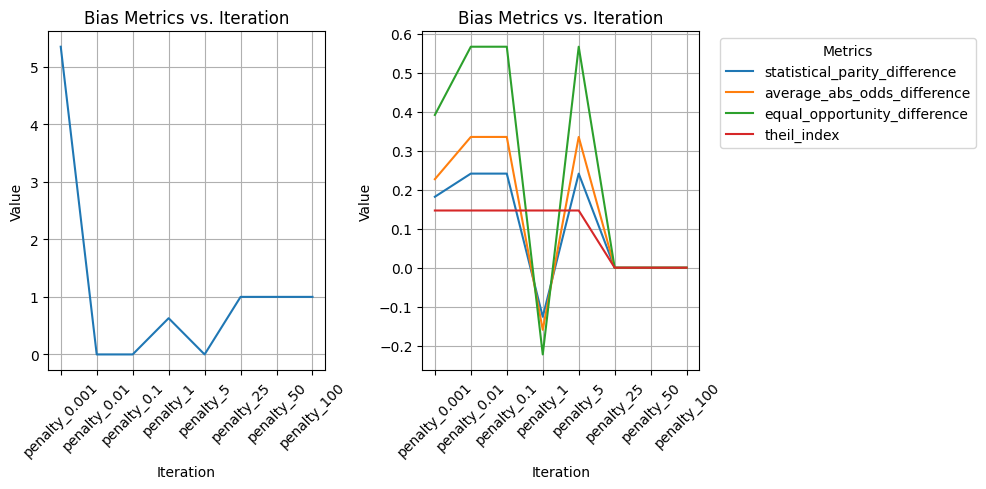

In [53]:
plot_fairness_metrics(df_fairness_metrics)

## Mitigation

In [54]:
from tqdm import tqdm
from sklearn import clone
from aif360.algorithms.preprocessing import Reweighing
from utils_fairness import create_aif360_standardDataset, compute_metrics, reweight_mitigation
from utils import plot_metrics

### Reweighting

In [57]:
# create (un)privileged groups
privileged_groups = [{key: 1 for key in list(privileged_subset[0].keys())}]
unprivileged_groups = [{key: 0 for key in list(privileged_subset[0].keys())}]

# convert dataset
train_dataset = create_aif360_standardDataset(df_train, nominal_features, target, 1, list(privileged_subset[0].keys()), list(privileged_subset[0].values()))
test_dataset = create_aif360_standardDataset(df_test, nominal_features, target, 1, list(privileged_subset[0].keys()), list(privileged_subset[0].values()))

# train model
model = clone(clf)
model.fit(train_dataset.features, train_dataset.labels.ravel())
y_pred = model.predict(train_dataset.features)

# model = create_model(clf, nominal_features)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_train)

# compare results
train_dataset_prediction = train_dataset.copy()
train_dataset_prediction.labels = y_pred.reshape(-1, 1)
train_dataset_prediction.scores = y_pred.reshape(-1, 1)
_ = compute_metrics(train_dataset, train_dataset_prediction, unprivileged_groups, privileged_groups)

Statistical parity difference = 0.2748
Disparate impact = inf
Average odds difference = nan
Equal opportunity difference = nan
Theil index = 0.1537


In [58]:
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
RW.fit(train_dataset)

train_dataset_reweight = RW.transform(train_dataset)

In [59]:
model = create_model(clf, nominal_features)

# original model
y_test, y_pred = train_and_evaluate(model, df_train, df_test, target, drop_na=True, sample_weight=None)
_ = describe_model(y_test, y_pred, verbose=True)

# mitigated model
y_test, y_pred = train_and_evaluate(model, df_train, df_test, target, drop_na=True, sample_weight=train_dataset_reweight.instance_weights)
_ = describe_model(y_test, y_pred, verbose=True)

Metric         Value               
Accuracy       0.817915752064388
Precision      0.7644810066229113
Recall         0.6911075355525242
F1             0.7138743025115764
Metric         Value               
Accuracy       0.8015051740357478
Precision      0.7598578995827883
Recall         0.6293740631205116
F1             0.6496954795147996


In [60]:
def check_for_equality(standart_dataset, column_name):
    df, _ = standart_dataset.convert_to_dataframe()
    df1_aligned, df2_aligned = df[column_name].align((df_train.dropna())[column_name], join='inner')

    if df1_aligned.equals(df2_aligned):
        print(f"Column '{column_name}' is the same in both DataFrames.")
    else:
        print(f"Column '{column_name}' differs in the DataFrames. Differences are at the following indices:")
        # Identify the indices where they differ
        differences = df1_aligned != df2_aligned
        differing_indices = differences[differences].index
        
        # Print the differing values and their indices
        for idx in differing_indices:
            print(f"Index {idx}: df1[{column_name}] = {df1_aligned.at[idx]}, df2[{column_name}] = {df2_aligned.at[idx]}")

In [61]:
for col in list(privileged_subset[0].keys()):
    check_for_equality(train_dataset_reweight, col)

Column 'relationship' differs in the DataFrames. Differences are at the following indices:
Column 'age' differs in the DataFrames. Differences are at the following indices:


In [62]:
df_fairness_metrics = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "average_abs_odds_difference",
        "equal_opportunity_difference",
        "disparate_impact",
        "theil_index",
    ]
)

df_metrics = pd.DataFrame(
    columns=['acc', 'prec', 'rec', 'f1']
)

weights = None

weights_hist = [weights]
max_iter = 10
for i in tqdm(range(max_iter)):
    X_train, y_train = split_data(df_train, target, True)
    X_test, y_test = split_data(df_test, target, True)
    weights, model_metrics, fair_metrics = reweight_mitigation(clf, nominal_features, target, X_train, y_train, X_test, y_test, penalty=5, sample_weights=weights)
    if model_metrics is None and fair_metrics is None and weights is None:
        break

    df_metrics.loc[f"mitigation_{i}"] = model_metrics.values()
    df_fairness_metrics.loc[f"mitigation_{i}"] = fair_metrics.values()
    weights_hist.append(weights)

100%|██████████| 10/10 [02:41<00:00, 16.20s/it]


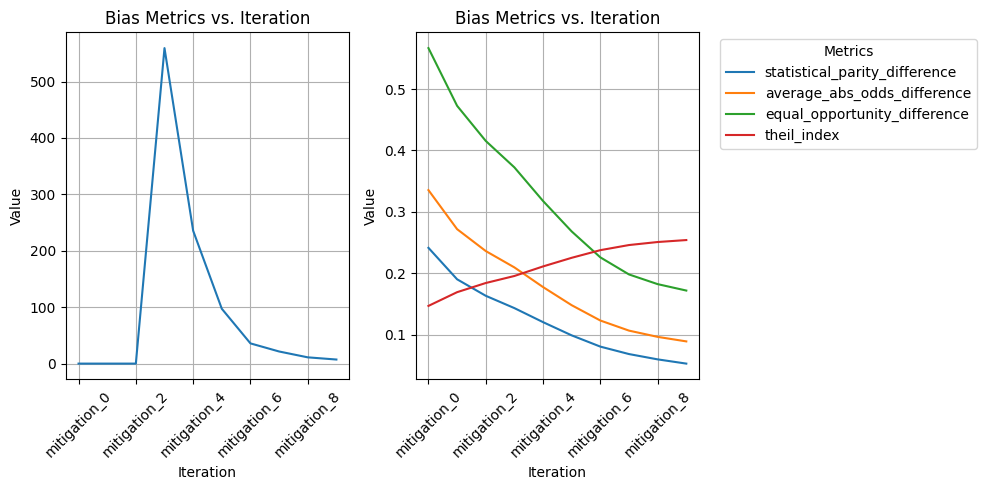

In [63]:
plot_fairness_metrics(df_fairness_metrics)

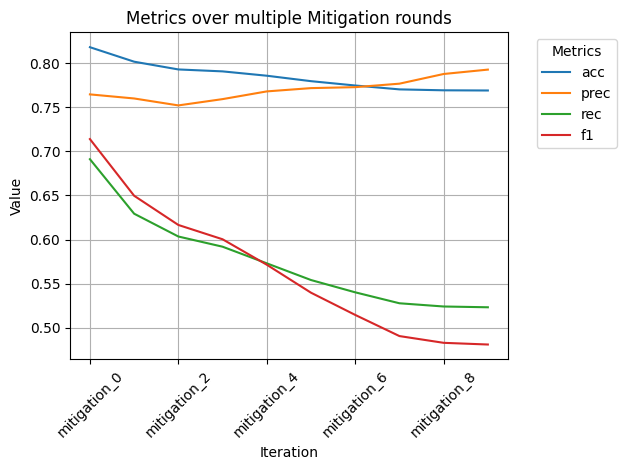

In [64]:
plot_metrics(df_metrics, 'Iteration', 'Value', 'Metrics over multiple Mitigation rounds')

### Fair Learning

In [65]:
from utils import prepare_data_fair_learning, plot_fairlearning_results
from utils_fairness import get_fair_learning_scoring

In [66]:
df_train_bias = transform_to_bias_dataset(df_train, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), verbose=True)
df_test_bias = transform_to_bias_dataset(df_test, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), verbose=True)

X_train, y_train, X_test, y_test = prepare_data_fair_learning(df_train_bias, df_test_bias, nominal_features, target)

In [67]:
max_delta = get_fair_learning_scoring(list(privileged_subset[0].keys()))

In [68]:
from sklearn.model_selection import GridSearchCV
from aif360.sklearn.preprocessing import LearnedFairRepresentations

lfr = LearnedFairRepresentations(list(privileged_subset[0].keys()), n_prototypes=25, max_iter=100, random_state=random_state)
params = {
    "reconstruct_weight": [1e-2, 1e-3, 1e-4],
    "target_weight": [100, 1000],
    "fairness_weight": [0, 100, 1000],
}

grid = GridSearchCV(lfr, params, scoring=max_delta, cv=3, n_jobs=-1).fit(X_train, y_train, priv_group=(1,)*len(list(privileged_subset[0].keys())))
res = pd.DataFrame(grid.cv_results_)
display(res)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/m

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fairness_weight,param_reconstruct_weight,param_target_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,12.660519,0.393747,0.072466,0.007648,0,0.0100,100,"{'fairness_weight': 0, 'reconstruct_weight': 0...",-0.644917,-0.619767,-0.634632,-0.633105,0.010324,9
1,13.099362,0.563765,0.072012,0.017211,0,0.0100,1000,"{'fairness_weight': 0, 'reconstruct_weight': 0...",-0.633995,-0.617832,-0.619140,-0.623656,0.007330,1
2,12.511715,0.479497,0.065844,0.004351,0,0.0010,100,"{'fairness_weight': 0, 'reconstruct_weight': 0...",-0.640476,-0.619527,-0.628323,-0.629442,0.008589,4
3,13.965446,0.857339,0.053849,0.005606,0,0.0010,1000,"{'fairness_weight': 0, 'reconstruct_weight': 0...",-0.641695,-0.615044,-0.622556,-0.626432,0.011220,2
4,14.567690,1.575849,0.066943,0.000499,0,0.0001,100,"{'fairness_weight': 0, 'reconstruct_weight': 0...",-0.643715,-0.619721,-0.626824,-0.630087,0.010063,7
5,14.097895,0.203259,0.059883,0.000261,0,0.0001,1000,"{'fairness_weight': 0, 'reconstruct_weight': 0...",-0.639590,-0.625946,-0.624619,-0.630051,0.006766,6
6,14.855618,0.578264,0.081418,0.029055,100,0.0100,100,"{'fairness_weight': 100, 'reconstruct_weight':...",-0.652581,-0.638692,-0.639342,-0.643538,0.006400,13
7,14.234037,0.730605,0.131680,0.042457,100,0.0100,1000,"{'fairness_weight': 100, 'reconstruct_weight':...",-0.641889,-0.624195,-0.628877,-0.631654,0.007485,8
8,15.159385,0.758056,0.123618,0.034965,100,0.0010,100,"{'fairness_weight': 100, 'reconstruct_weight':...",-0.650133,-0.638433,-0.646076,-0.644881,0.004851,14
9,14.559911,0.858985,0.082162,0.012615,100,0.0010,1000,"{'fairness_weight': 100, 'reconstruct_weight':...",-0.637475,-0.620750,-0.627910,-0.628711,0.006852,3


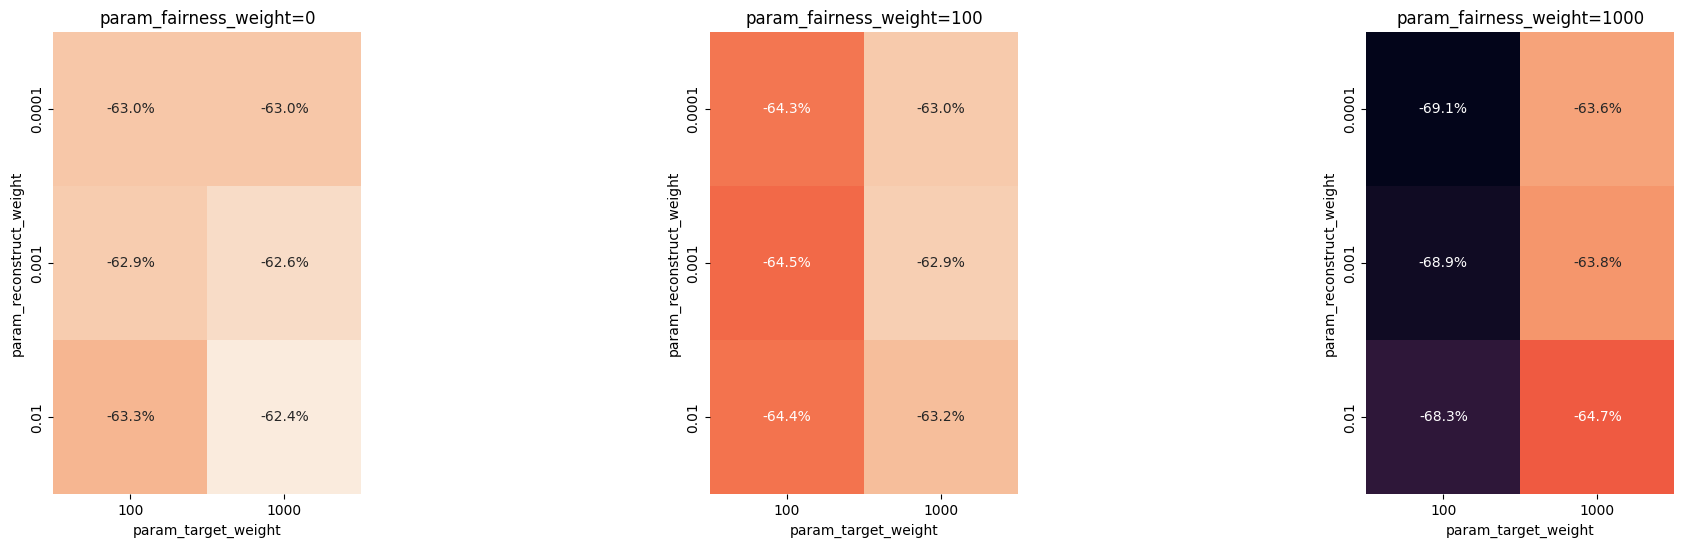

In [69]:
plot_fairlearning_results(res)

In [72]:
model = create_model(clf, [])

In [77]:
model.fit(X_train, y_train)

_ = describe_model(y_test, model.predict(X_test), verbose=True)
_ = describe_fairness(y_train, model.predict(X_train), list(privileged_subset[0].keys()) ,verbose=True)

Metric         Value               
Accuracy       0.817915752064388
Precision      0.7644810066229113
Recall         0.6911075355525242
F1             0.7138743025115764
Metric                          Value               
statistical_parity_difference   0.24133993148077656
average_odds_difference         0.33540995486646463
equal_opportunity_difference    0.5668475579674396
disparate_impact                            0.0
theil_index                     0.14676388895384265


In [78]:
_ = describe_model(y_test, grid.predict(X_test), verbose=True)
_ = describe_fairness(y_train, grid.predict(X_train), list(privileged_subset[0].keys()) ,verbose=True)

Metric         Value               
Accuracy       0.8132120832026759
Precision      0.776067175662196
Recall         0.6574233871676802
F1             0.6826803418668892
Metric                          Value               
statistical_parity_difference   0.17604169716845774
average_odds_difference         0.25142892733573113
equal_opportunity_difference    0.4369018253576714
disparate_impact                            0.0
theil_index                     0.17940879937526058


In [79]:
model.fit(grid.transform(X_train), y_train)

_ = describe_model(y_test, model.predict(grid.transform(X_test)), verbose=True)
_ = describe_fairness(y_train, model.predict(X_train), list(privileged_subset[0].keys()) ,verbose=True)
_ = describe_fairness(y_train, model.predict(grid.transform(X_train)), list(privileged_subset[0].keys()) ,verbose=True)

Metric         Value               
Accuracy       0.8218877391031671
Precision      0.7771434323338544
Recall         0.6889709927576098
F1             0.714292023561359
Metric                          Value               
statistical_parity_difference   0.09187773906083774
average_odds_difference         0.5404794241844497
equal_opportunity_difference    0.9973359644795264
disparate_impact                1.1037114854811192
theil_index                     0.040558691181709544
Metric                          Value               
statistical_parity_difference   0.22523498579836607
average_odds_difference         0.31238235313934765
equal_opportunity_difference    0.5267883571780957
disparate_impact                            0.0
theil_index                     0.15796427429448553


Multiple Runs cannot be done, because of the dataset already needs to be one hot encoded for the mitigation, making the `search_bias` function unnecessary and returning not viable resolutions.

### Fair Adapt